In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"

# info = nee_file.split('/')[-1].split('.')
# var_name = info[0]
# ML_method = info[3]
# year = info[7]
# partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)


In [2]:
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr
from rasterio.io import MemoryFile

ds = xr.open_dataset(nee_file)
ds = ds.rio.write_crs("EPSG:4326")

ds['NEE'][0].rio.write_crs('EPSG:4326', inplace=True)
ds['NEE'][0].rio.write_transform(nee_transform, inplace=True)

# # Save to an in-memory GeoTIFF
memfile = MemoryFile()
with memfile.open(
    driver="GTiff",
    height=ds['NEE'][0].shape[0],
    width=ds['NEE'][0].shape[1],
    count=1,
    dtype=ds['NEE'][0].dtype.name,
    crs=ds['NEE'][0].rio.crs,
    transform=nee_transform,
) as dst:
    # Write the data to the in-memory file
    dst.write(ds['NEE'][0].values, 1)


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

msa_file = '../urban_greening/msa/michiganMSA_reprojected.shp'
gpp_file = "../urban_greening/nov.15/michigan_test/modis-250-gpp-2015001.tif"

nlcd_file = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
ua_file = "../urban_greening/gis_processed/ua/ua_30.tif"


msa=gpd.read_file(msa_file)
msa=msa[msa['NAMELSAD']=='Grand Rapids-Wyoming-Kentwood, MI Metro Area'] # Subsetting to my AOI



with rasterio.open(gpp_file) as gpp_dstrd:
    msa_crsgpp=msa.to_crs(gpp_dstrd.crs)
    msa_crs = msa_crsgpp.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,msa_crsgpp.geometry,crop=True)
    

    # replace fillvalue 65535 with np.nan
    gpp_clip_image = np.where(gpp_clip_image == 65535, np.nan, gpp_clip_image) 

    gpp_msa = gpp_clip_image[0]

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)
        
        
        
        # Clip the raster using the reprojected geometries
        nlcd_clip_image, nlcd_clip_transform = mask(nlcd_dstrd, geometries, crop=True)
        
        nlcd_msa = nlcd_clip_image[0]

        

        import numpy as np
        gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32) #make it support nan
        # gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=gpp_dstrd.meta['dtype']), 
        from rasterio.enums import Resampling
        from rasterio.warp import calculate_default_transform, reproject
        reproject(
            source=gpp_msa,
            destination=gpp_msa_rr,
            src_transform=gpp_clip_transform,
            src_crs=gpp_crs,
            dst_transform=nlcd_clip_transform,
            dst_crs=nlcd_crs,
            resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            src_nodata=np.nan
        )
        
       

        with rasterio.open(ua_file) as ua_dstrd:
            ua_crs = ua_dstrd.crs

            ua_clip_image, ua_clip_transform = mask(ua_dstrd, geometries, crop=True)
            ua_msa = ua_clip_image[:][:][0]

            import numpy as np
            ua_msa_rr = np.empty((ua_clip_image.shape[1], ua_clip_image.shape[2]), dtype=ua_dstrd.meta['dtype'])

            from rasterio.enums import Resampling
            from rasterio.warp import calculate_default_transform, reproject
            reproject(
                source=ua_msa,
                destination=ua_msa_rr,
                src_transform=ua_clip_transform,
                src_crs=ua_crs,
                dst_transform=nlcd_clip_transform,
                dst_crs=nlcd_crs,
                resampling=Resampling.nearest
            )

        # nee_month_us_file = '../output/nee.tif'
        # with rasterio.open(nee_month_us_file) as nee_dstrd:
        with memfile.open() as nee_dstrd:
            nee_crs = gpp_crs
            
            # clip nee raster with shape
            nee_clip_image, nee_clip_transform = mask(nee_dstrd, [mapping(geom) for geom in msa_crsgpp.geometry], crop=True, all_touched=True)  # Include all touched pixels)
            nee_clip_image = np.where(nee_clip_image == -9999, np.nan, nee_clip_image) 
            
            nee_msa = nee_clip_image[0]

        memfile.close()


In [4]:
def save_tiff(output_file, output_path, crs, transform):
    # Write the ndarray to a GeoTIFF
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=output_file.shape[0],
        width=output_file.shape[1],
        count=1,  # Number of bands
        dtype=output_file.dtype,
        crs=crs,
        transform=transform,
        # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
    ) as dst:
        # Write data to the first band
        dst.write(output_file, 1)

    print(f"GeoTIFF saved to {output_path}")

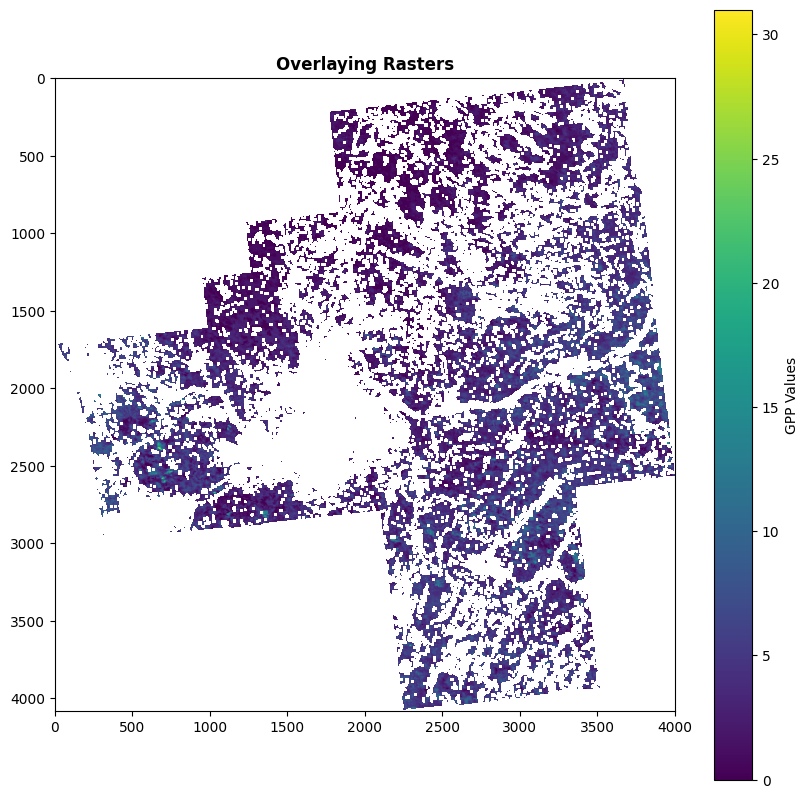

In [5]:
from rasterio import plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
# Show the first raster
rasterio.plot.show(gpp_msa_rr, ax=ax, alpha=0.8, title="Overlaying Rasters")
cax = ax.imshow(gpp_msa_rr, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")

# Show the second raster as an overlay
# rasterio.plot.show(nlcd_msa, ax=ax, alpha=1)  # Adjust alpha for transparency

# rasterio.plot.show(ua_msa_rr, ax=ax, alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

In [6]:
valid_gpp_mask = ~np.isnan(gpp_msa_rr)
urban_mask = (ua_msa_rr != 0)
suburban_mask = (ua_msa_rr == 0)
forest_mask = (nlcd_msa == 41) | (nlcd_msa == 42) | (nlcd_msa == 43)
shrub_mask = (nlcd_msa == 51) | (nlcd_msa == 52)
grass_mask = (nlcd_msa > 70) & (nlcd_msa < 90)
wetland_mask = (nlcd_msa >= 90) & (nlcd_msa < 100)

# TODO: urban developed, and set to 0 for mean_gpp
nlcd_mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask,
    'urban_grass': urban_mask & grass_mask,
    'suburban_grass': suburban_mask & grass_mask,
    'urban_wetland': urban_mask & wetland_mask,
    'suburban_wetland': suburban_mask & wetland_mask,
}

{'name': 'test_msa', 'urban_forest': np.float32(3.259661), 'suburban_forest': np.float32(3.4994838), 'urban_shrub': np.float32(2.8415134), 'suburban_shrub': np.float32(3.856921), 'urban_grass': np.float32(3.4969804), 'suburban_grass': np.float32(3.6307428), 'urban_wetland': np.float32(3.2366927), 'suburban_wetland': np.float32(3.4754617)}


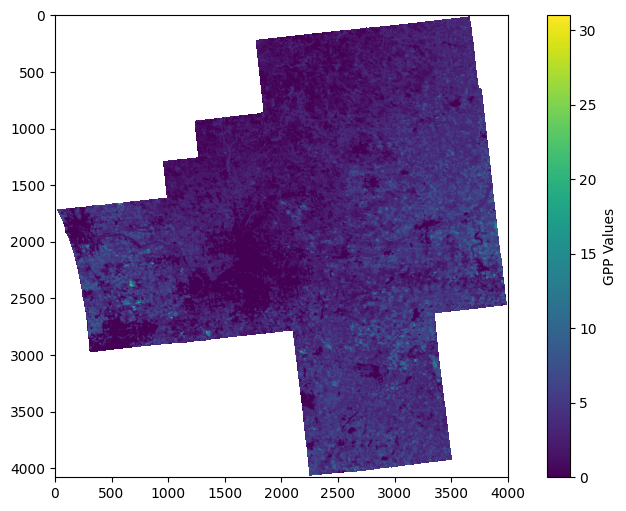

In [7]:
from rasterio.features import geometry_mask
import rasterstats

gpp_msa_rr_filled = np.copy(gpp_msa_rr)

category_gpp_mean_list = []
record = {'name': 'test_msa'}

water_mask = (nlcd_msa > 10) & (nlcd_msa < 20)
developed_mask = (nlcd_msa > 20) & (nlcd_msa < 40)

gpp_msa_rr_filled[~valid_gpp_mask & water_mask] = 0
gpp_msa_rr_filled[~valid_gpp_mask & developed_mask] = 0
# gpp_msa_rr_filled[water_mask] = 0
# gpp_msa_rr_filled[developed_mask] = 0
                  
for category, landcover_mask in nlcd_mask_dict.items():

    category_gpp_mean = np.nanmean(gpp_msa_rr[landcover_mask])
    record[category] = category_gpp_mean
    
    gpp_msa_rr_filled[~valid_gpp_mask & landcover_mask] = category_gpp_mean

print(record)

fig, ax = plt.subplots(figsize=(10, 6)) 
cax = ax.imshow(gpp_msa_rr_filled, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")
plt.show()

In [8]:
gpp_filled_coarse = np.empty_like(nee_msa, dtype=np.float32)

# Reproject and resample GPP to match NEE's CRS, resolution, and extent
reproject(
    source=gpp_msa_rr_filled,  # Your filled GPP raster
    destination=gpp_filled_coarse,  # Empty array to hold the resampled data
    src_transform=nlcd_clip_transform,  # Transform of the original GPP data
    src_crs=nlcd_crs,  # CRS of the original GPP data
    dst_transform=nee_clip_transform,  # Transform of the clipped NEE data
    dst_crs=nee_crs,  # CRS of the clipped NEE data
    resampling=Resampling.average,  # Use nearest neighbor resampling
    src_nodata=np.nan,  # Set source nodata value
    dst_nodata=np.nan  # Set destination nodata value
)

(array([[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 1.2887832 ,
         1.1677084 , 0.8607344 , 1.185199  , 1.2348671 , 1.9544193 ,
         2.3781197 , 2.9231138 , 3.4187448 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 0.9346591 ,
         0.9376677 , 1.1026587 , 1.1135019 , 1.8031448 , 2.20597   ,
         2.2993975 , 2.917863  , 3.2912557 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan, 0.87421155, 1.3369215 , 1.2622857 , 1.2012293 ,
         1.8084481 , 1.2881111 , 1.6599634 , 1.8000906 , 2.3702643 ,
         2.8326204 , 3.1081676 , 3.6570787 ],
        [       nan,        nan,        nan,        nan,        nan,
         1.2201896 , 1.0081544 , 1.3383278 , 1.480771  , 1.2993472 ,
         1.4061729 , 2.1305146 , 2.170825  , 2.4903233 , 3.8344533 ,
         3.6405323 , 4.019512  , 4

In [9]:
save_tiff(gpp_msa_rr_filled, '../output/gpp_msa_rr_filled3.tif', nlcd_crs, nlcd_clip_transform)
save_tiff(gpp_filled_coarse, '../output/gpp_filled_coarse3.tif', nee_crs, nee_clip_transform)

# save_tiff(nee_msa, '../output/nee_msa2.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/gpp_msa_rr_filled3.tif
GeoTIFF saved to ../output/gpp_filled_coarse3.tif


In [10]:

save_tiff(nee_msa / gpp_filled_coarse, '../output/nee_gpp_ration3.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/nee_gpp_ration3.tif


In [11]:
nee_gpp_ratio_fine = np.empty_like(gpp_msa_rr_filled, dtype=np.float32)

# Reproject and resample GPP to match NEE's CRS, resolution, and extent
reproject(
    source=nee_msa / gpp_filled_coarse,  # Your filled GPP raster
    destination=nee_gpp_ratio_fine,  # Empty array to hold the resampled data
    src_transform=nee_clip_transform,  # Transform of the original GPP data
    src_crs=nee_crs,  # CRS of the original GPP data
    dst_transform=nlcd_clip_transform,  # Transform of the clipped NEE data
    dst_crs=nlcd_crs,  # CRS of the clipped NEE data
    resampling=Resampling.nearest,  # Use nearest neighbor resampling
    src_nodata=np.nan,  # Set source nodata value
    dst_nodata=np.nan  # Set destination nodata value
)


(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 Affine(30.0, 0.0, 786105.0,
        0.0, -30.0, 2327445.0))

In [14]:
save_tiff(nee_gpp_ratio_fine * gpp_msa_rr_filled, '../output/downscaled_nee3.tif', nlcd_crs, nlcd_clip_transform)

GeoTIFF saved to ../output/downscaled_nee3.tif
